# Eczamine Deep Learning Model (EczaNet)

In [70]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/EczaNet

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/EczaNet


In [71]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [72]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from time import sleep

<br><br><br><br>
Using Microsoft Cognitive Services we can use Bing Image Search.
Once you've set `key`, you can use `search_images_bing`.

In [73]:
key = os.environ.get('AZURE_SEARCH_KEY', 'b9117fd6254c4253bc7f47c64cb8947a')

<br><br><br><br>
The URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term). Let's look at one...

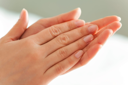

In [74]:
results = search_images_bing(key, 'hands')
ims = results.attrgot('content_url')

dest = 'images/hands.jpg' #make sure `images` dir exists
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

<br><br><br><br>
Download 150 datapoints (images) for each class and put them into classes/class1, classes/class2, etc.

In [75]:
classes = 'eczema','healthy'
path = Path('hands')

# May cause ERROR - `BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.` caused by trying to multithread
if not path.exists():
    path.mkdir()
    for c in classes:
        dest = (path/c[:2])
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{c} hands')
        download_images(dest, urls=results.attrgot('content_url'))
        sleep(2) # 2 second to not overload cognitive services

In [76]:
# To remove all the failed images, you can use `unlink` (delete) on each of them.
fns = get_image_files(path)
failed = verify_images(fns)
print(f'failed to verify {len(failed)} images and removed')
failed.map(Path.unlink);

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9 bytes but only got 8. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)


failed to verify 0 images and removed


<br><br><br><br>
Create `Dataloader` to serve data using `DataBlock`

In [83]:
hands = DataBlock(
    blocks=(ImageBlock, CategoryBlock),              # image -> category
    get_items=get_image_files,                       # takes path, returns list of all images in that path (recursively)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% of dataset used for validation
    get_y=parent_label,                              # use parent folder as label for class
    item_tfms=Resize(128))                           # resize all images to 128 by 128

dls = hands.dataloaders(path)

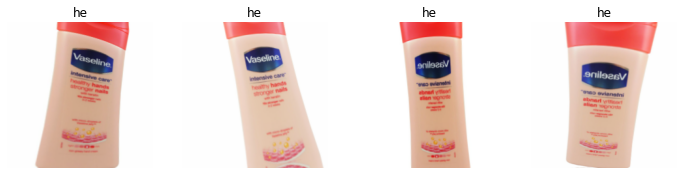

In [84]:
# Let's have a look at the RandomResizedCrop batch
hands = hands.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = hands.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

<br><br><br><br>
Train model using trasnfer learning and resnet18 as base

In [79]:
# tranfer learning using cnn and resnet18 with a batchsize=4 
# dls.num_workers = 0 
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.487185,0.721685,0.368421,00:12


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9 bytes but only got 8. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)


epoch,train_loss,valid_loss,error_rate,time
0,0.844990,0.498087,0.298246,00:12
1,0.745046,0.309161,0.157895,00:12
2,0.570847,0.269938,0.105263,00:11
3,0.474203,0.286875,0.122807,00:12
4,0.391448,0.289694,0.122807,00:12
5,0.346998,0.276433,0.105263,00:12


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9 bytes but only got 8. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9 bytes but only got 8. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in byte

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9 bytes but only got 8. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)


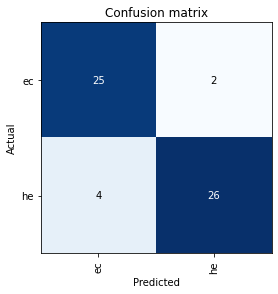

In [80]:
# view confusion matrix (contingency table / cross tabulation)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

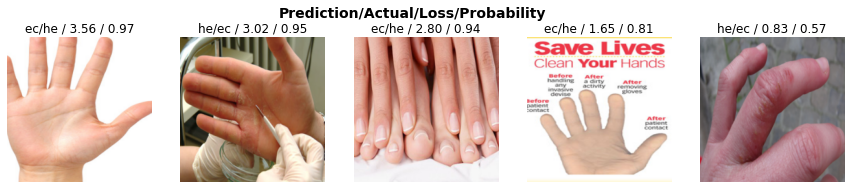

In [81]:
# the 5 worst predictions by the model
interp.plot_top_losses(5, nrows=1)

`ImageClassifierCleaner` allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling

In [82]:
# remove / relabel highest-loss images using a GUI
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9 bytes but only got 8. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)
